# Parking Tickets 
Lets do basic exploratory analysis on this Toronto parking-ticket [dataset](https://open.toronto.ca/dataset/parking-tickets/) to uncover insights. We parametrize our analysis with the following settings:

In [1]:
settings = {
    'years': list(range(2019, 2023)),   # optional specific years to look at.
    'sample_fraction': 0.2,             # optional % of data to randomly sub-sample for speedup
    'random_seed': 42,                  # optional for reproducibility
    'top_n_infractions': 3,             # look at most frequent N infractions only
}

### Data Preparation

Here we import the necessary libraries & load the raw dataset into a memory dataframe (from archived zip files rather than download for reproducibility).

In [7]:
from lib.helpers import *
from address_parser import Parser
from datetime import datetime
import matplotlib.pyplot as plt
import glob
import calendar
import pandas as pd
import seaborn as sns
sns.set_theme(style="darkgrid")

df = pd.concat((
    pd.read_csv(file, compression='zip', header=0, sep=',')
    for year in settings.get('years', [""])
    for file in glob.glob(f"data/Parking_Tags_Data_{year}*.csv.zip")
), ignore_index=True)

Next, we cleanup this raw dataframe by removing unecessary columns, formatting types, simplifying values & dropping rows with missing data.

In [8]:
# remove unnecessary columns to save working memory.
df.drop([
    'tag_number_masked',    # anonymized ticket num, no longer unique
    'infraction_code',      # redundant with infraction desc
    'location1',            # unnecessary relative positioning
    'location3',            # mostly missing
    'location4',            # mostly missing
], axis=1, inplace=True)

# remove rows having missing values in any of these necessary columns
df.dropna(subset=[
    'date_of_infraction',   # must have local date
    'time_of_infraction',   # must have 24hr time
    'set_fine_amount',      # must have ticket $$ value
    'location2',            # must have street addr
   #'province',             # empty are unknowns
], inplace=True)

# Converts a numerical 24hr clock value formatted as "234.0" to denote "02:34"
# Handles time cycles.
def convert_time(t: float) -> datetime.time:
    t = f'{round(t):04}'         # ignore secs & zero pad
    h = f'{int(t[:2]) % 24:02}'  # loop & accumulate hrs
    m = f'{int(t[2:]) % 60:02}'  # loop & accumulate min
    return datetime.strptime(f"{h}{m}", "%H%M").time()

# convert columns types & cleanup values
df['date_of_infraction'] = pd.to_datetime(df['date_of_infraction'], format='ISO8601')
df['time_of_infraction'] = df['time_of_infraction'].apply(convert_time)
df['province'] = df['province'].str.upper()


> **⚠️ _NOTE:_** 
Given that the City of Toronto has already excluded incomplete records from the dataset, us further filtering out the low volume of rows with missing critical values should not significantly affect results. 

To enrich this dataset with deeper insights, we can feature engineer the following columns:
* geocode lat/lng from address
* zone of address (ie: commercial, residential, industrial)
* type of street (ie: avenue, road, alley, ..)
* weather conditions at time
* traffic & construction conditions at time

In [9]:
# TODO!

To speedup downstream analysis, we finalize our raw & enriched dataset by taking a random sample of parking-tickets throughout yeach of the analysis years.

In [5]:
# subsample dataset for speedup
df = df.sample(
    frac=settings['sample_fraction'],
    random_state=settings['random_seed'],
)

print("DATA OVERVIEW")
display(df_overview(df))

print("EXAMPLE ROWS")
display(df.head())

DATA OVERVIEW


,counts,%_missing,%_unique,dtype
column_name,,,,
date_of_infraction,1383135,0.0%,0.11%,datetime64[ns]
infraction_description,1383135,0.0%,0.01%,object
set_fine_amount,1383135,0.0%,0.0%,int64
time_of_infraction,1383135,0.0%,0.1%,object
location2,1383135,0.0%,13.48%,object
province,1383135,0.0%,0.0%,object


EXAMPLE ROWS


,date_of_infraction,infraction_description,set_fine_amount,time_of_infraction,location2,province
1345348,2019-09-28,PARK ON PRIVATE PROPERTY,30,05:00:00,3370 KINGSTON RD,ON
45308,2019-02-27,PARK ON PRIVATE PROPERTY,30,21:33:00,174 JOHN GARLAND BLVD,ON
793234,2019-04-13,PARK IN A FIRE ROUTE,250,01:36:00,2600 FINCH AVE W,ON
2178666,2019-07-24,PARK-SIGNED HWY-PROHIBIT DY/TM,50,20:30:00,15 MARINE PARADE DR,ON
4672298,2021-06-23,PARK ON PRIVATE PROPERTY,30,23:34:00,150 LONG BRANCH AVE,ON


### Temporal Analysis

For visualization purposes, lets look at the top most frequent parking infractions in the dataset & aggregate the rest.

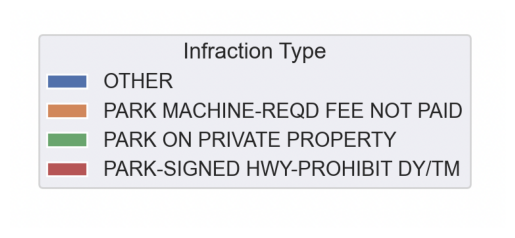

In [24]:
# tally specific infraction types, typically the top most ones & group them by (hour, day, month) period
def plot_histogram_infractions(df: pd.DataFrame, period: str, infractions: set):
    lbls = \
        list(range(24)) if period == 'hour' else \
        list(calendar.day_abbr) if period == 'day' else \
        list(calendar.month_abbr) if period == 'month' else \
        []

    df_tmp = (
        df['time_of_infraction'].apply(lambda t: t.hour) if period == 'hour' else
        df['date_of_infraction'].dt.dayofweek if period == 'day' else
        df['date_of_infraction'].dt.month if period == 'month' else
        df['date_of_infraction']
    ).to_frame(period)

    df_tmp = df_tmp.join(df['infraction_description'].apply(
        lambda infraction: infraction if infraction in infractions else "OTHER"
    ).to_frame('infraction_description'))
    df_tmp = df_tmp.groupby([period, 'infraction_description']).size().to_frame('counts')
    df_tmp = df_tmp.unstack(level=-1, fill_value=0)
    df_tmp = 100 * df_tmp / df_tmp.sum(axis='columns').sum()  # relative
    df_tmp.rename(
        index=dict(enumerate(lbls)),
        inplace=True,
        errors='ignore',
    )
    df_tmp.columns = df_tmp.columns.droplevel()
    return df_tmp

# since there are many to visualize, get the top most 
# frequent N infractions in dataset.
top_infractions = set(
    df['infraction_description']
      .value_counts()
      .nlargest(settings.get('top_n_infractions', 3))
      .keys()
)

# NOTE: Figure out how to display standalone & common legend.
# Resolving these issues: (1) show legend before plots, (2)
# show multiple visuals per cell, (3) show legend figure. 

# show the legend from pre-generated image.
img = mpimg.imread('image/top_infractions_legend.png')
plt.imshow(img)
plt.axis('off')
plt.show()
'''
# construct lengend depends on plot axis.
fig_legend = plt.figure()
handles, labels = ax.get_legend_handles_labels()
fig_legend.legend(
    handles,
    labels,
    title="Infraction Type",
    loc='center',
)
fig_legend.show()
''';

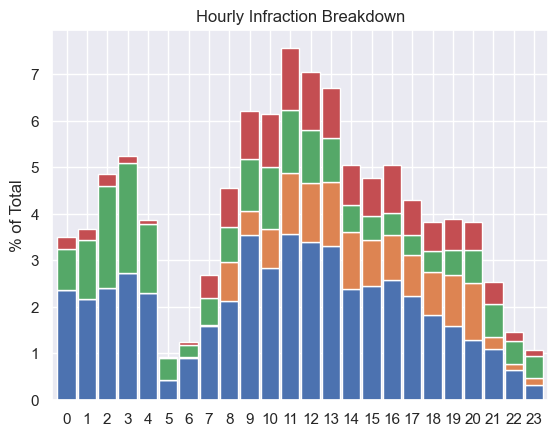

In [26]:
ax = plot_histogram_infractions(df, period='hour', infractions=top_infractions).plot(
    kind='bar', stacked=True, width=0.9, legend=False,
    title="Hourly Infraction Breakdown",
    xlabel="",
    ylabel='% of Total',
    rot=0,
)

Activity throughout the day reveals:
1. _most infractions occur at lunchtime_ <br>
Presumably this is when most of the population (& parking ticket staff) are active to commit infractions & be caught.

1. _unpaid meter infractions happen only during the day_ <br>

1. _parking on private property is more problematic at night_ <br>

1. _abnormal number of violations in the early morning_ <br>
At days end, we would expect a similar number of violations between consiecutives hours. However between 12am - 4am, there is an unexplainable excess distribution of activity. Perhaps this is freight & trucking related to city by-laws, OR perhaps this is a mismatch in time of recording. More investigation is requried.



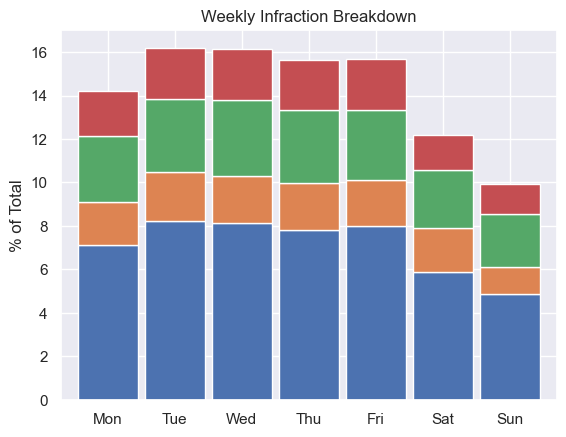

In [27]:
ax = plot_histogram_infractions(df, period='day', infractions=top_infractions).plot(
    kind='bar', stacked=True, width=0.9, legend=False,
    title="Weekly Infraction Breakdown",
    xlabel="",
    ylabel='% of Total',
    rot=0,
)

Parking activity throughout the week reveals:
1. _less activity is seen on weekends_ <br>
> **⚠️ _NOTE:_** 
Perhaps there is a sampling bias here as there might be less staff working on weekends to catch violations or there is trully less driving activity occuring on the weekends. More data is needed to tease out.

1. _consistent daily behaviour_ <br>
Eventhough week vs weekend infraction volumes change a bit in abosolut, the proportional breakdown of infractions each day are identical suggesting public behaviour remains constant throughout the week.






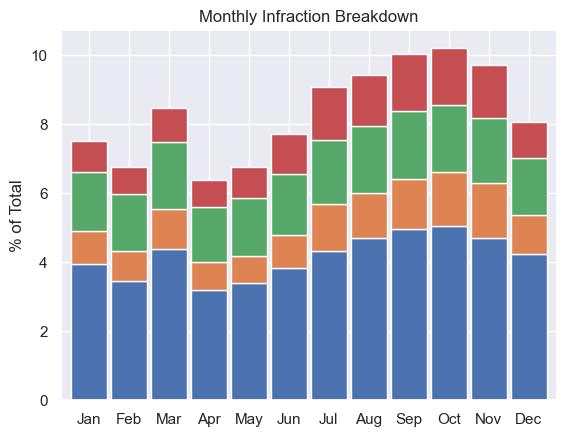

In [28]:
ax = plot_histogram_infractions(df, period='month', infractions=top_infractions).plot(
    kind='bar', stacked=True, width=0.9, legend=False,
    title="Monthly Infraction Breakdown",
    xlabel="",
    ylabel='% of Total',
    rot=0,
)

Parking activity throughout the year reveals:

1. _seasonality trends exist_ <br>
With late summer & early fall showing the most violations, this can be explained by tourism & back-to-school behaviours.

1. _march activity is abnormaly inflated_ <br>
> **⚠️ _NOTE:_** 
Perhaps the fiscal cycle for the City of Toronto starts in April (tax time) which could explain the spike in reported traffic violations. Further analysis is needed.





### Insights

#### 📐 Parking Quotas
Is there evidence that parking violations are issued in certain areas at certain perriods to meet police quotas?

#### 🧳 Local vs Foreign
Are vehicles with foregin licenses equaly likely to get parking violations as local vehicles?

#### 🦠 COVID Effects
Where there changes in parking violations due to pandemic work-from-home behavours?

In [ ]:
# time series of overal infractions per week.
ax = sns.lineplot(
    data=df.groupby(
        [pd.Grouper(key='date_of_infraction', freq='W')]
    ).size().to_frame('volume'),
)
ax.set_title('Weekly Infractions')
ax.set_xlabel('date')
ax.set_ylabel('volume')
ax.tick_params(axis='x', rotation=90)
ax.get_legend().set_visible(False)

# plot key time markers.
covid_shutdowns = {
    datetime(2020, 3, 17), # 1st wave
    datetime(2020, 10, 2), # 2nd preventive wave
    datetime(2021, 4, 3),  # 3rd emergency wave
}
for d in covid_shutdowns:
    ax.axvline(
        x=d, 
        linestyle='dashed',
        color='red',
        alpha=0.3
    )
display(ax)

Based on [wikipedia's](https://en.wikipedia.org/wiki/COVID-19_pandemic_in_Toronto) timeline of COVID shutdowns in Toronto (denoted by doted red vertical lines), we see the volume of parking violations were imediately affected in each of the pandemic waves.